<a href="https://colab.research.google.com/github/Serbeld/RX-COVID-19/blob/master/Detection5C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pandas as pd

plt.rcParams["figure.figsize"] = (10,5)


In [3]:
#Loading the dataset
!pip install h5py
import h5py

from google.colab import drive,files
drive.mount('/content/drive')

hdf5_path = '/content/drive/My Drive/Dataset_lungs/Dataset5C.hdf5'

dataset = h5py.File(hdf5_path, "r")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pylab as plt

#train
train_img = dataset["train_img"]

xt = np.array(train_img)
yt = np.array(dataset["train_labels"])

#test
testX = np.array(dataset["test_img"])
testY = np.array(dataset["test_labels"])

#Validation
xval = np.array(dataset["val_img"])
yval = np.array(dataset["val_labels"])

In [5]:
print("Training Shape: "+ str(xt.shape))
print("Validation Shape: "+ str(xval.shape))
print("Testing Shape: "+ str(testX.shape))

Training Shape: (4690, 512, 512, 3)
Validation Shape: (1005, 512, 512, 3)
Testing Shape: (1005, 512, 512, 3)



Healthy:                              [1 0 0 0 0]
Pneumonia & Covid-19:                 [0 1 0 0 0]
Cardiomegaly:                         [0 0 1 0 0]
Other respiratory disease:            [0 0 0 1 0]
Pleural Effusion:                     [0 0 0 0 1]

Output:                               [1. 0. 0. 0. 0.]


Using TensorFlow backend.


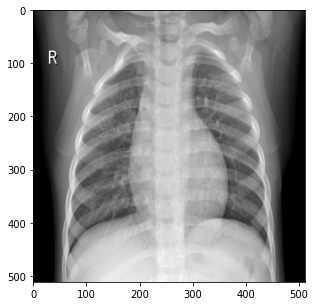

In [6]:
#Categorical values or OneHot
import keras

num_classes = 5

yt = keras.utils.to_categorical(yt,num_classes)
testY = keras.utils.to_categorical(testY,num_classes)
yval = keras.utils.to_categorical(yval,num_classes)

#Image
num_image = 15

print()
print('Healthy:                              [1 0 0 0 0]')
print('Pneumonia & Covid-19:                 [0 1 0 0 0]')
print('Cardiomegaly:                         [0 0 1 0 0]')
print('Other respiratory disease:            [0 0 0 1 0]')
print('Pleural Effusion:                     [0 0 0 0 1]')

print()
print("Output:                               "+ str(yt[num_image]))

imagen =  train_img[num_image]
plt.imshow(imagen)
plt.show()

In [0]:
## global params
INIT_LR = 1e-5  # learning rate
EPOCHS = 10  # training epochs
BS = 4  # batch size

In [8]:
## build network
from tensorflow.keras.models import load_model

#Inputs
inputs = Input(shape=(512, 512, 3), name='images')

#Inception Model
output1 = inception_v3.InceptionV3(include_top=False,weights= "imagenet", 
                                  input_shape=(512, 512, 3),
                                  classes = 5)(inputs)

#AveragePooling2D
output = AveragePooling2D(pool_size=(4, 4), strides=None, 
                          padding='valid',name='AvgPooling')(output1)

#Flattened
output = Flatten(name='Flatten')(output)

#ReLU layer
output = Dense(1000, activation = 'relu',name='ReLU')(output)

#Dropout
output = Dropout(0.35,name='Dropout')(output)

#Dense layer
output = Dense(5, activation='softmax',name='softmax')(output)

# the actual model train)
model = Model(inputs=inputs, outputs=output)

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
AvgPooling (AveragePooling2D (None, 3, 3, 2048)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
ReLU (Dense)                 (None, 1000)              18433000  
_________________________________________________________________
Dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
softmax (Dense)              (None,

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/Dataset_lungs/Model",
                                       monitor='val_loss', save_best_only=True)

## train
print("[INFO] training head...")
H = model.fit({'images': xt}, 
              {'softmax': yt}, 
              batch_size = BS,
              epochs = EPOCHS,
              validation_data=(xval, yval),
              callbacks=[model_checkpoint],
              shuffle=True)


[INFO] training head...
Epoch 1/10
1173/1173 [==============================] - ETA: 0s - loss: 0.8754 - accuracy: 0.6249WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Dataset_lungs/Model/assets
1173/1173 [==============================] - 202s 173ms/step - loss: 0.8754 - accuracy: 0.6249 - val_loss: 0.7832 - val_accuracy: 0.6438
Epoch 2/10
1173/1173 [==============================] - 200s 170ms/step - loss: 0.5303 - accuracy: 0.7932 - val_loss: 0.5075 - val_accuracy: 0.8249
Epoch 3/10
1173/1173 [==============================] - 200s 170ms/step - loss: 0.3464 - accuracy: 0.8682 - val_loss: 0.4695 - val_accuracy: 0.8249
Epo

In [0]:
#Load the best model trained
model = load_model("/content/drive/My Drive/Dataset_lungs/Model")

In [18]:
## eval
print("[INFO] evaluating network...")
print()
print("Loss: "+ str(round(model.evaluate(testX,testY,verbose=0)[0],2))+ " Acc: "+ str(round(model.evaluate(testX,testY,verbose=1)[1],2)))
print()

predIdxs = model.predict(testX)
predIdxs = np.argmax(predIdxs, axis=1) # argmax for the predicted probability
#print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
#print(total) #60

acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3,3]+ cm[4,4]) / total

#sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
#specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
#print("sensitivity: {:.4f}".format(sensitivity))
#print("specificity: {:.4f}".format(specificity))


[INFO] evaluating network...

32/32 [==============================] - 6s 186ms/step - loss: 0.5449 - accuracy: 0.7891
Loss: 0.54 Acc: 0.79

[[163   6   0   0   0]
 [  5 178   6   8  13]
 [  0   0 173  12   8]
 [  0   5  25 113  70]
 [  0   2  13  39 166]]
acc: 0.7891


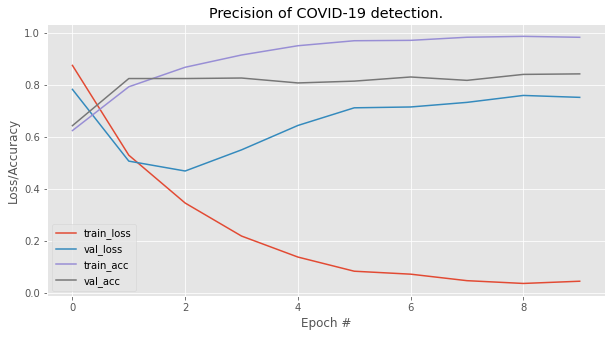

In [12]:
## explain
N = EPOCHS
plt.style.use("ggplot")
plt.figure(1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Precision of COVID-19 detection.")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.axis([0, EPOCHS, 0.3, 0.9])
plt.savefig("/content/drive/My Drive/Dataset_lungs/Model/trained_cero_plot_Inception_2nd_time.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 2 - predicted: 3


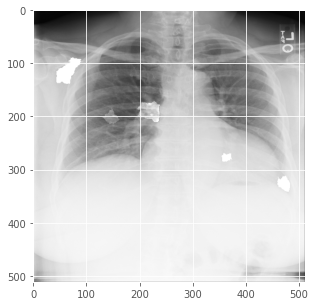

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 3 - predicted: 4


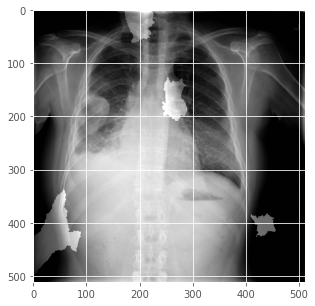

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 0 - predicted: 1


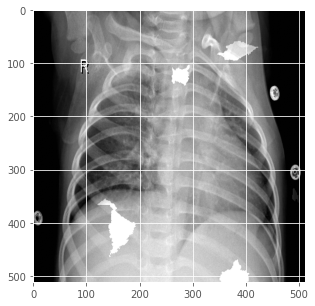

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 1 - predicted: 1


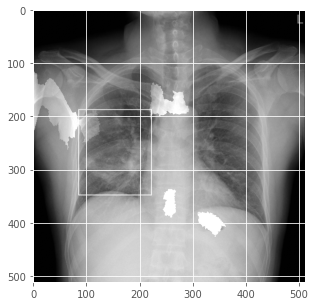

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 0 - predicted: 0


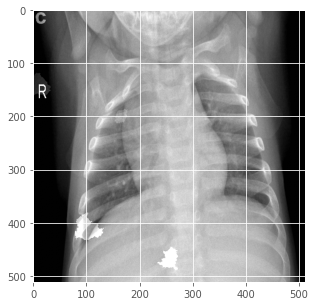

In [13]:
import cv2

plt.figure(2)
for ind in range(5): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    mask = np.array(mark_boundaries(temp/2 +1, mask))
    #print(mask.shape)
    imagen = testX[ind]
    imagen[:,:,0] = imagen[:,:,2]
    imagen[:,:,1] = imagen[:,:,2]
    mask[:,:,0] = mask[:,:,2]
    mask[:,:,1] = mask[:,:,2]
    plt.imshow((mask +imagen)/255)
    plt.savefig("/content/drive/My Drive/Dataset_lungs/Model/trained_pulmons_inception_Normal"+str(ind)+".png")
    plt.show()


> label: 2 - predicted: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


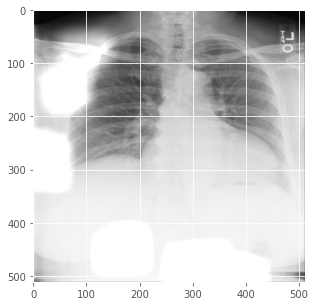

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 3 - predicted: 4


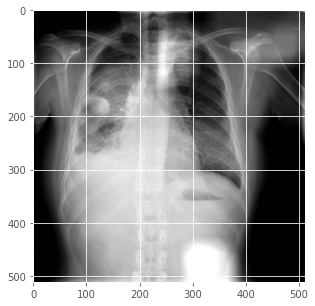

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 0 - predicted: 1


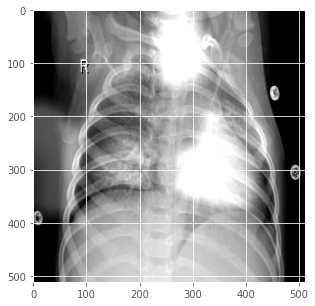

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 1 - predicted: 1


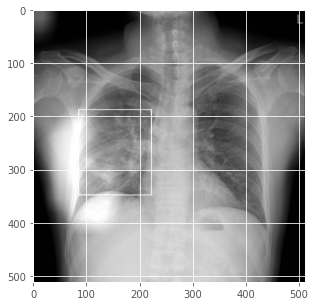

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



> label: 0 - predicted: 0


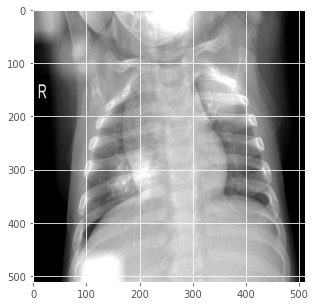

In [14]:
plt.figure(3)
for ind in range(5): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    mask = np.array(mark_boundaries(temp/2 +1, mask))
    #print(mask.shape)
    imagen = testX[ind]
    imagen[:,:,0] = imagen[:,:,2]
    imagen[:,:,1] = imagen[:,:,2]
    mask[:,:,0] = mask[:,:,2]
    mask[:,:,1] = mask[:,:,2]
    kernel = np.ones((50,50),np.uint8)
    mask = cv2.dilate(mask,kernel,iterations = 1)
    mask = cv2.blur(mask,(30,30))
    plt.imshow((mask +imagen)/255)
    plt.savefig("/content/drive/My Drive/Dataset_lungs/Model/trained_pulmons_inception_Light"+str(ind)+".png")
    plt.show()


> label: 2 - predicted: 3


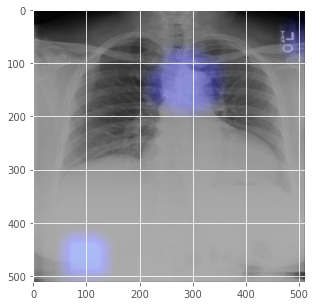


> label: 3 - predicted: 4


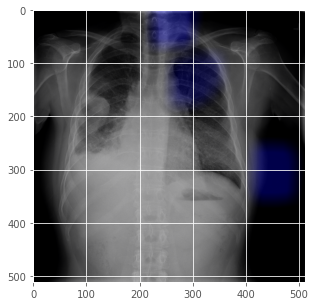


> label: 0 - predicted: 1


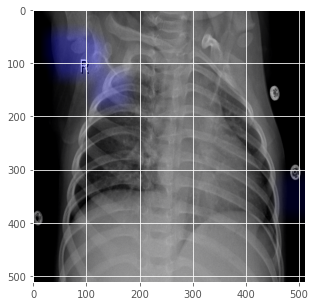


> label: 1 - predicted: 1


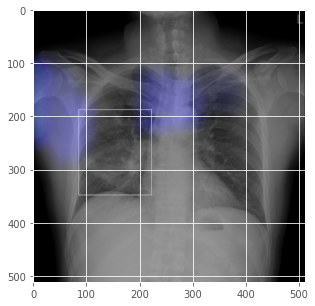


> label: 0 - predicted: 0


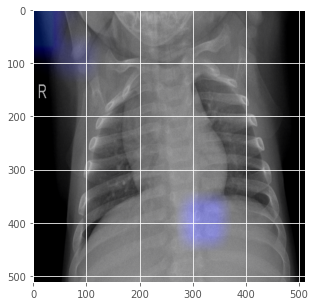


> label: 4 - predicted: 3


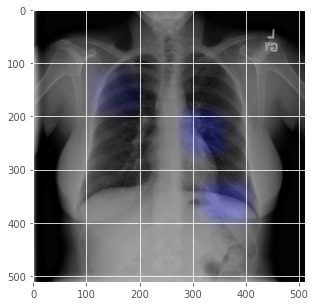


> label: 1 - predicted: 1


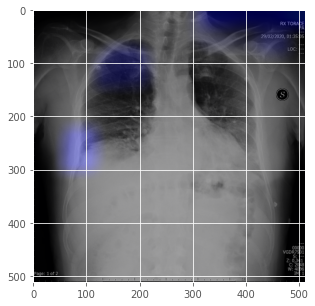


> label: 3 - predicted: 4


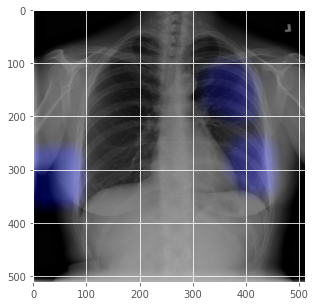


> label: 1 - predicted: 1


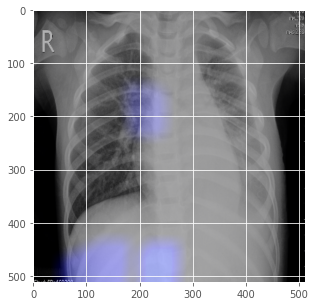


> label: 2 - predicted: 2


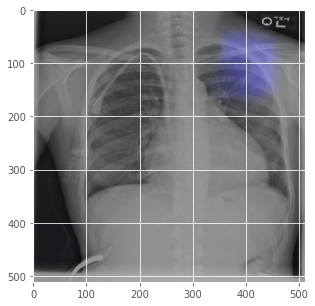

In [15]:
plt.figure(4)

for ind in range(10): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
    mask = np.array(mark_boundaries(temp/2 +1, mask))
    #print(mask.shape)
    imagen = testX[ind]
    imagen[:,:,0] = imagen[:,:,2]
    imagen[:,:,1] = imagen[:,:,2]
    mask[:,:,0] = mask[:,:,2]
    mask[:,:,1] = mask[:,:,2]
    kernel = np.ones((50,50),np.uint8)
    mask = cv2.dilate(mask,kernel,iterations = 1)
    mask = cv2.blur(mask,(30,30))
    mask = np.array(mask, dtype=np.uint8)
    mask = cv2.medianBlur(mask,5)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.applyColorMap(mask, cv2.COLORMAP_HOT) #heatmap
    end = cv2.addWeighted((imagen/255), 0.7, mask/255, 0.3, 0)
    plt.imshow((end))
    plt.savefig("/content/drive/My Drive/Dataset_lungs/Model/trained_pulmons_inception_Heat_map_purple"+str(ind)+".png")
    plt.show()


> label: 2 - predicted: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


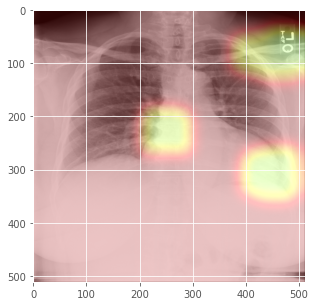


> label: 3 - predicted: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


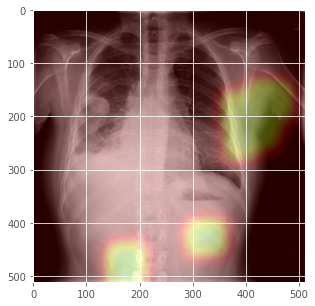


> label: 0 - predicted: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


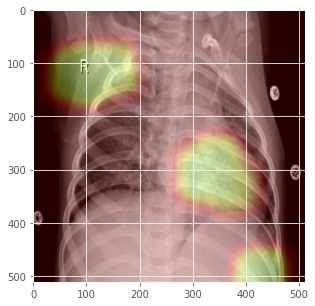


> label: 1 - predicted: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


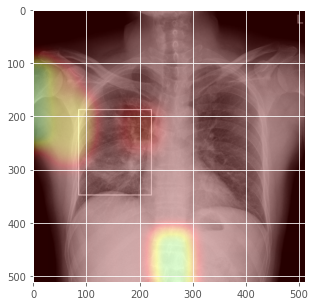


> label: 0 - predicted: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


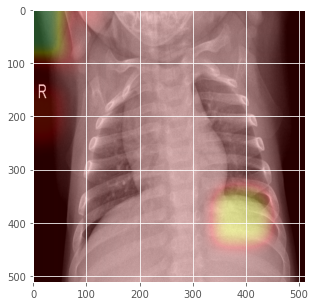


> label: 4 - predicted: 3


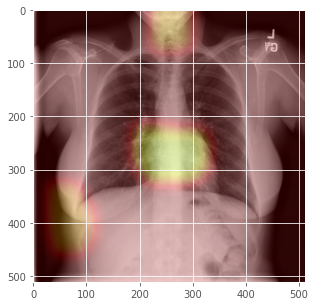


> label: 1 - predicted: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


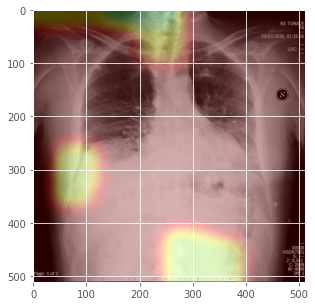


> label: 3 - predicted: 4


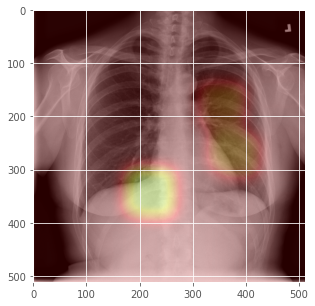


> label: 1 - predicted: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


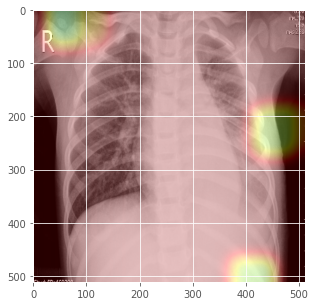


> label: 2 - predicted: 2


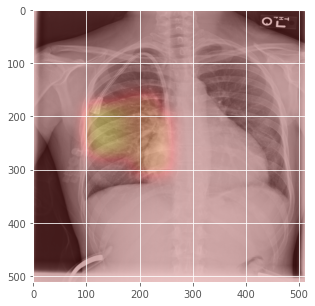

In [16]:
plt.figure(4)
for ind in range(10): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
    mask = np.array(mark_boundaries(temp/2 +1, mask))
    #print(mask.shape)
    imagen = testX[ind]
    imagen[:,:,0] = imagen[:,:,2]
    imagen[:,:,1] = imagen[:,:,2]
    mask[:,:,0] = mask[:,:,2]
    mask[:,:,1] = mask[:,:,2]
    kernel = np.ones((30,30),np.uint8)
    mask = cv2.dilate(mask,kernel,iterations = 2)
    mask = cv2.blur(mask,(30,30))
    mask = cv2.blur(mask,(30,30))
    mask = np.array(mask, dtype=np.uint8)
    mask = cv2.medianBlur(mask,5)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask2 = cv2.applyColorMap((mask), cv2.COLORMAP_JET) #heatmap

    mask = cv2.blur(mask,(60,60))
    mask = cv2.applyColorMap(mask, cv2.COLORMAP_HOT) #heatmap

    mask = ((mask*1.1 + mask2*0.7)/255)*(3/2)
    end = cv2.addWeighted(imagen/255, 0.8, mask2/255, 0.3, 0)
    #end = cv2.addWeighted(end, 0.8, mask/255, 0.2, 0)
    plt.imshow((end))
    plt.savefig("/content/drive/My Drive/Dataset_lungs/Model/trained_pulmons_inception_Heat_map"+str(ind)+".png")
    plt.show()